In [2]:
import pandas as pd

hitter_df = pd.read_csv("data_scraping/hitters_data.csv")

/var/folders/dg/x_0nm1fs4813040r8nczfsfm0000gn/T/ipykernel_13742/3506135607.py:3: DtypeWarning: Columns (13,15,36) have mixed types. Specify dtype option on import or set low_memory=False.
  hitter_df = pd.read_csv("data_scraping/hitters_data.csv")


## Clean Hitter DF

In [3]:
def is_home_team(match):
    if match.startswith('v'):
        return True
    elif match.startswith('@'):
        return False
    else:
        return None

hitter_df.drop(['Unnamed: 0'], axis=1, inplace=True)
hitter_df.drop(['day'], axis=1, inplace=True)
hitter_df.drop(['month'], axis=1, inplace=True)
hitter_df.drop(['game_pk'], axis=1, inplace=True)
hitter_df.drop(['Stats_Summary'], axis=1, inplace=True)
hitter_df.drop(['game_2_dh'], axis=1, inplace=True)
hitter_df['home_team'] = hitter_df['Opp'].apply(is_home_team)
hitter_df['dk_salary'] = hitter_df['dk_salary'].str.replace('$', '').str.replace(',', '').astype(float)
hitter_df['fd_salary'] = hitter_df['fd_salary'].str.replace('$', '').str.replace(',', '').astype(float)
hitter_df['yh_salary'] = hitter_df['yh_salary'].str.replace('$', '').str.replace(',', '').astype(float)

def extract_team(value):
    return value.split('(')[0].strip()

hitter_df['Opp'] = hitter_df['Opp'].str.replace('@', '').str.replace('v', '')
hitter_df['Opp'] = hitter_df['Opp'].apply(extract_team)
hitter_df['Opp'] = hitter_df['Opp'].apply(lambda x: "away_" + x)

## Create Position Dummies

In [4]:
def create_position_dummy_variables(number):
    
    list = [False, False, False, False, False, False]
    digits = [int(digit) for digit in str(number)]
    for num in digits:
        if 7 <= num <= 9:
            list[5]= True
        else:
            list[num - 2] = True
            
    return list

def add_position_dummies(hitter_df):
    dummy_variables = hitter_df['Position'].apply(create_position_dummy_variables)
    dummy_df = pd.DataFrame(dummy_variables.tolist(), columns=[f'position_{i}' for i in range(2, 8)])
    hitter_df = pd.concat([hitter_df, dummy_df], axis=1)
    return hitter_df

In [5]:
hitter_df = add_position_dummies(hitter_df)
hitter_df['Position'] = hitter_df['Position'].apply(lambda x: str(x)[0])

## Correct FanDuel scoring

In [7]:
def calc_fd_points(row):
    singles = row['hits'] - (row['doubles'] + row['triples'] + row['hrs'])
    return 3 * singles + 6 * row['doubles'] + 9 * row['triples'] + 12 * row['hrs'] + 3.5 * row['rbis'] + 3.2 * row['runs'] + 3 * row['bbs'] + 6 * row['sb'] + 3 * row['hbp']

In [8]:
hitter_df['fd_points'] = hitter_df.apply(lambda row: calc_fd_points(row), axis=1)

## Add Day of Season Number

In [9]:
def add_date_num(df):
    date_df = df[['game_date', 'year']]
    date_df = date_df.drop_duplicates()
    date_df['day_num'] = date_df.groupby(['year']).cumcount() + 1
    
    return pd.merge(df, date_df.drop(['year'], axis=1), on='game_date', how='left')

In [10]:
hitter_df = add_date_num(hitter_df)

# EDA

In [11]:
import matplotlib.pyplot as plt

def plot_long_data(plt_label, column_name, df, groups=None):
    if groups is None:
        groups = ['day_num', 'year']
    grouped_df = df.groupby(groups)[column_name].mean().unstack()
    plt.figure(figsize=(10, 6))
    for column in grouped_df.columns:
        plt.plot(grouped_df.index, grouped_df[column], label=str(column))

    plt.xlabel('Day Number')
    plt.ylabel(plt_label) 
    plt.title(plt_label)
    plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_long_data_company(df, company, plot_label, column_name, groups=None):
    new_df = df.copy()
    new_df[company + '_salary_lagged'] = new_df.groupby(['Name', 'year'])[company + '_salary'].shift(1)
    if (company != 'fd'):
        new_df.drop(['fd_points', 'fd_salary'], axis=1, inplace=True)
    if (company != 'yh'):
       new_df.drop(['yh_points', 'yh_salary'], axis=1, inplace=True) 
    if (company != 'dk'):
       new_df.drop(['dk_points', 'dk_salary'], axis=1, inplace=True) 
        
    plot_long_data(plot_label, column_name, df, groups)
    
    
    

## Salary Visualizations By Year

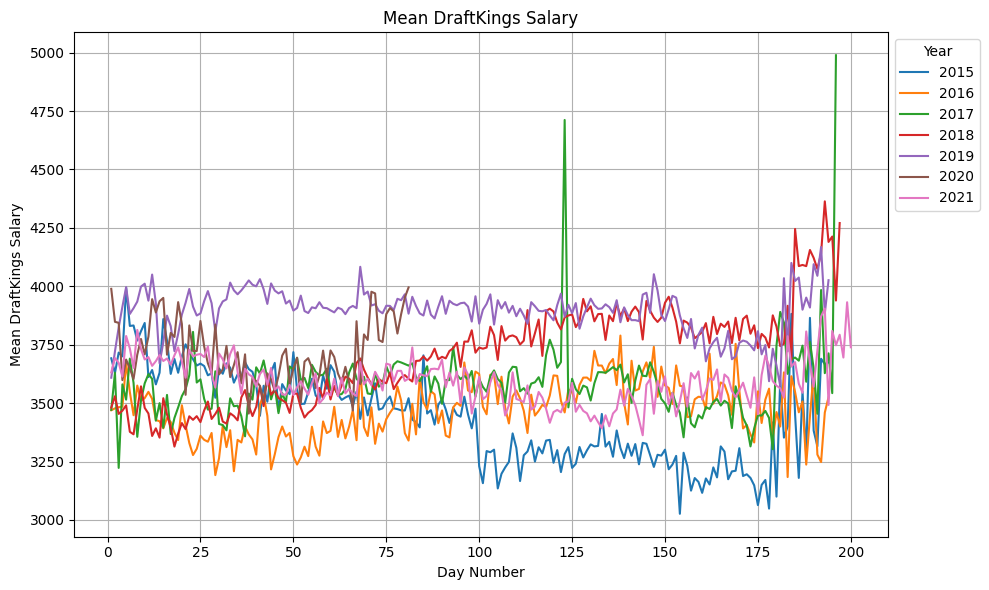

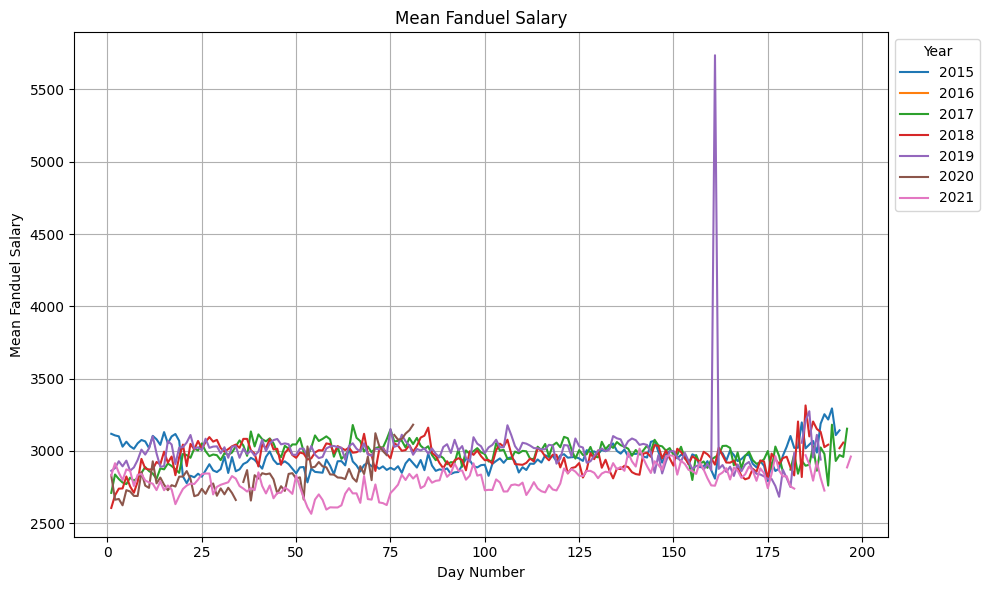

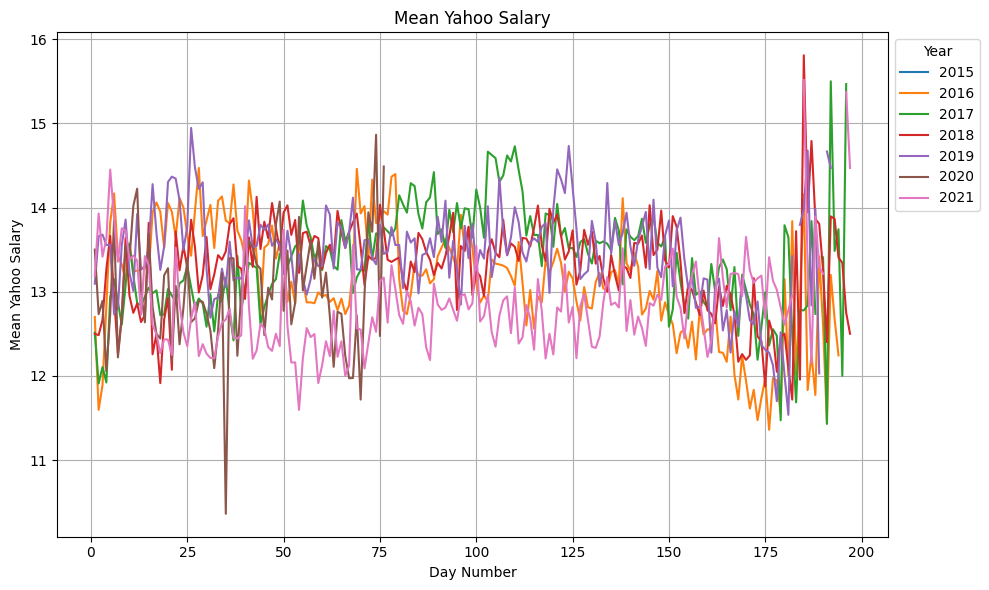

In [12]:
plot_long_data_company(hitter_df, "dk", 'Mean DraftKings Salary', 'dk_salary')
plot_long_data_company(hitter_df, 'fd', 'Mean Fanduel Salary', 'fd_salary')
plot_long_data_company(hitter_df, 'yh', 'Mean Yahoo Salary', 'yh_salary')

## Score Visualizations by Year

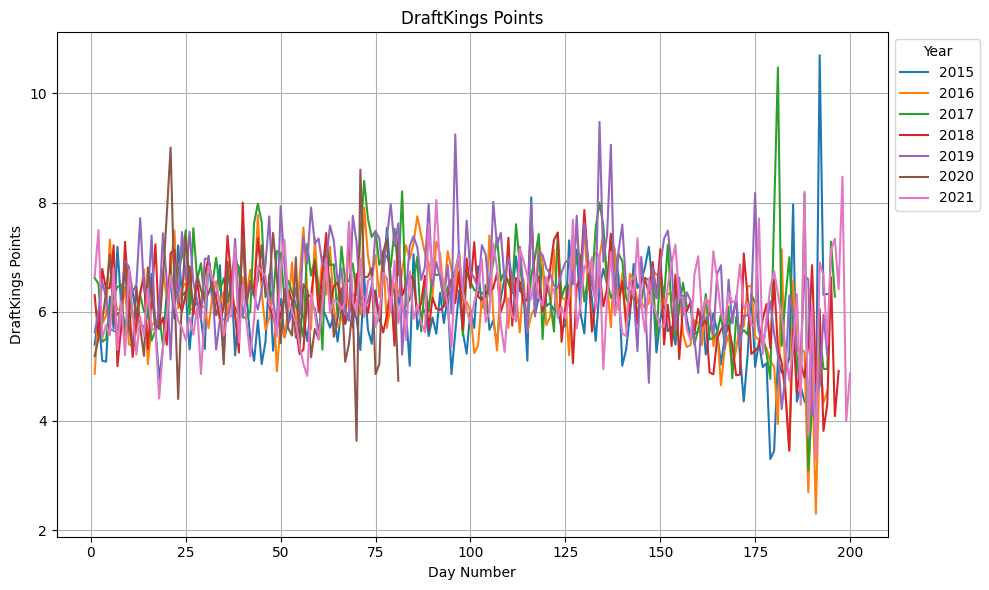

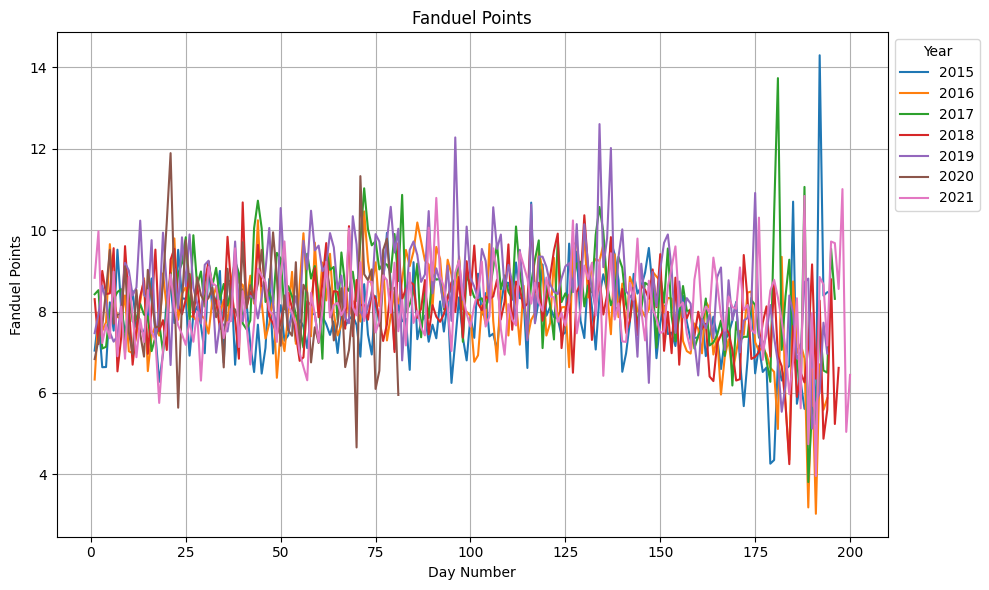

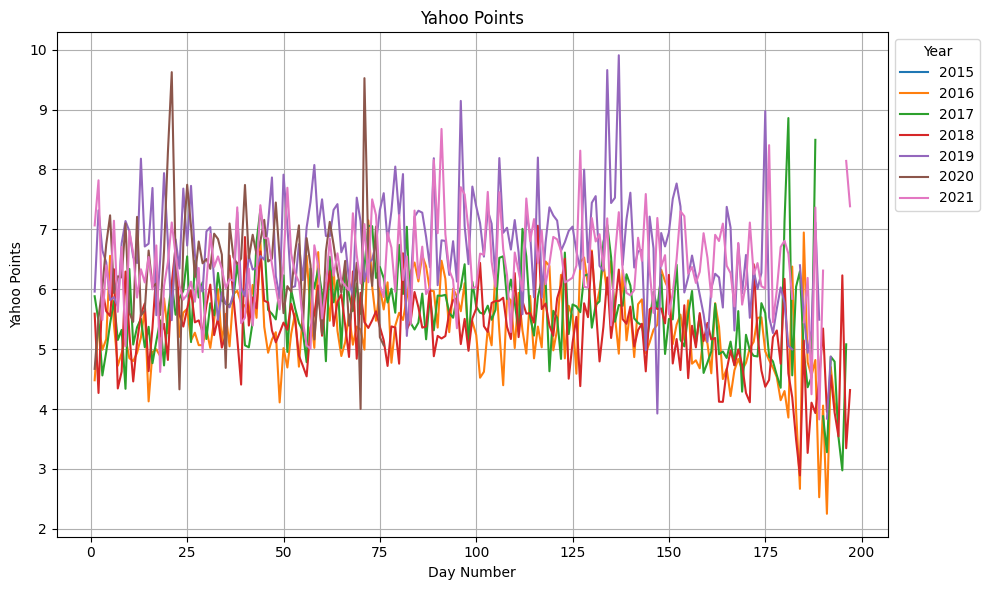

In [13]:
plot_long_data_company(hitter_df, "dk", 'DraftKings Points', 'dk_points')
plot_long_data_company(hitter_df, 'fd', 'Fanduel Points', 'fd_points')
plot_long_data_company(hitter_df, 'yh', 'Yahoo Points', 'yh_points')

##  Plotting Salary By Position

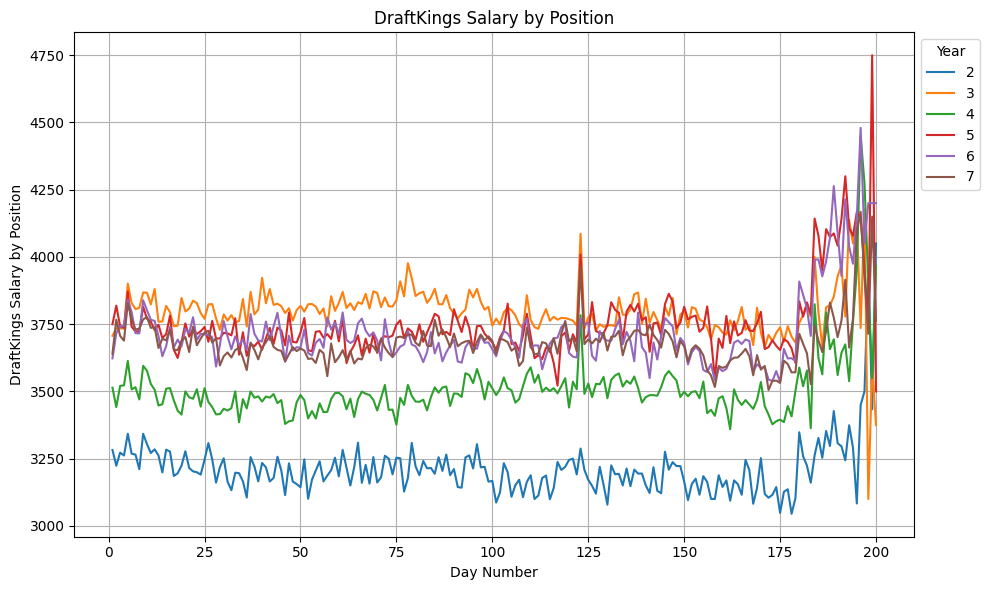

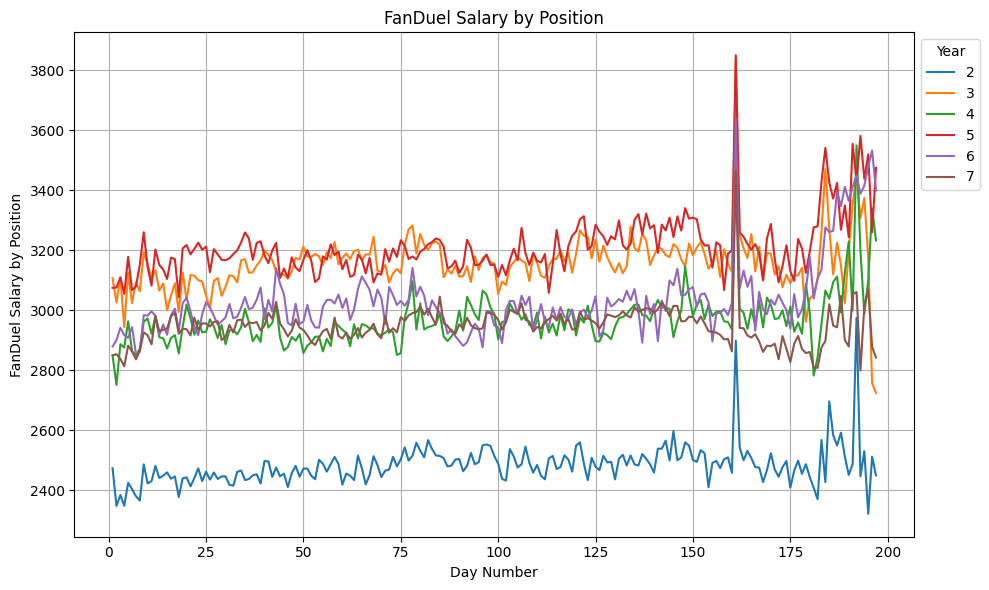

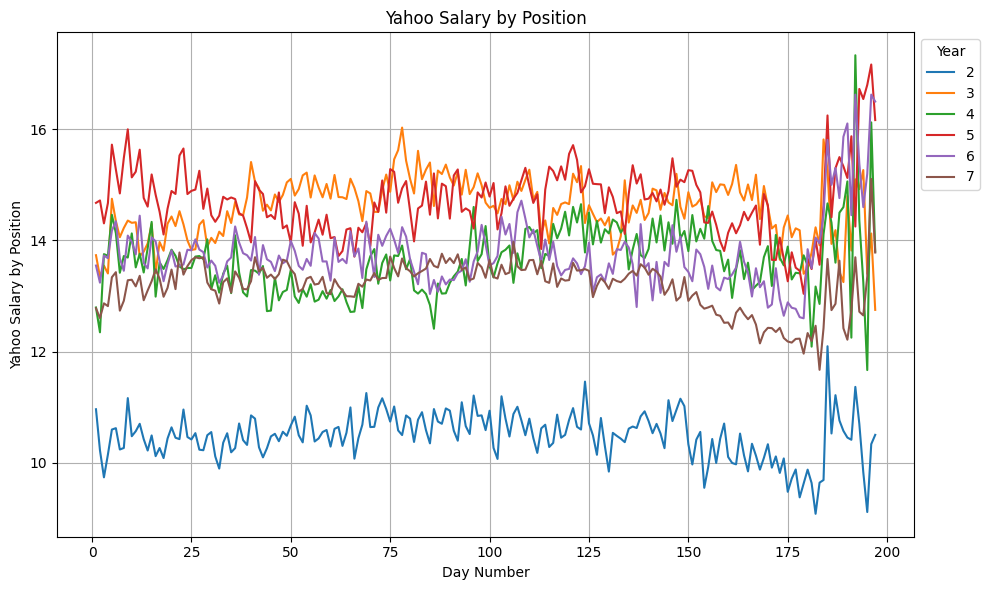

In [14]:
plot_long_data_company(hitter_df, "dk", 'DraftKings Salary by Position', 'dk_salary', ["day_num", 'Position'])
plot_long_data_company(hitter_df, "fd", 'FanDuel Salary by Position', 'fd_salary', ["day_num", 'Position'])
plot_long_data_company(hitter_df, "yh", 'Yahoo Salary by Position', 'yh_salary', ["day_num", 'Position'])

## Plotting Points By Position

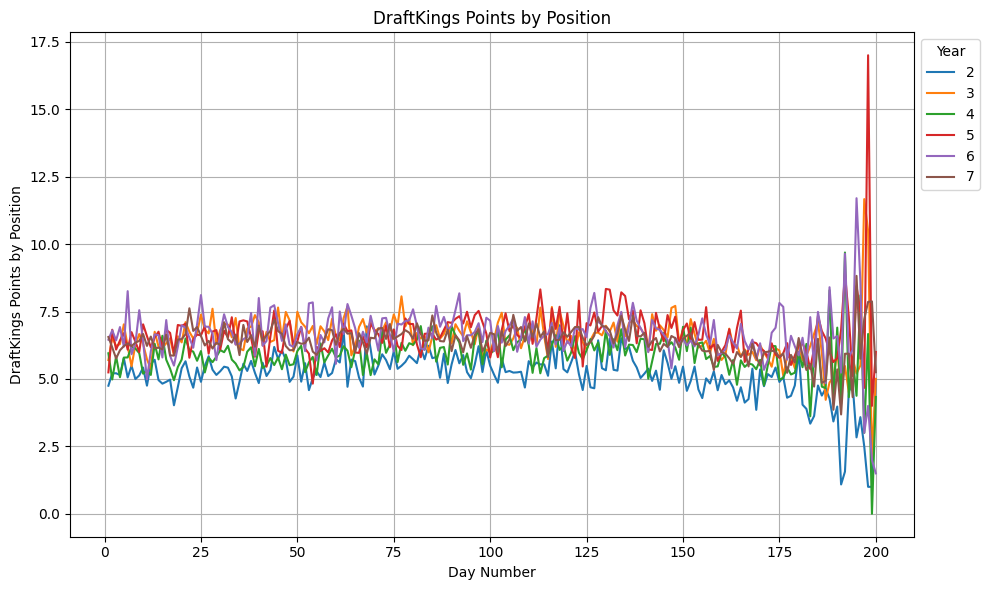

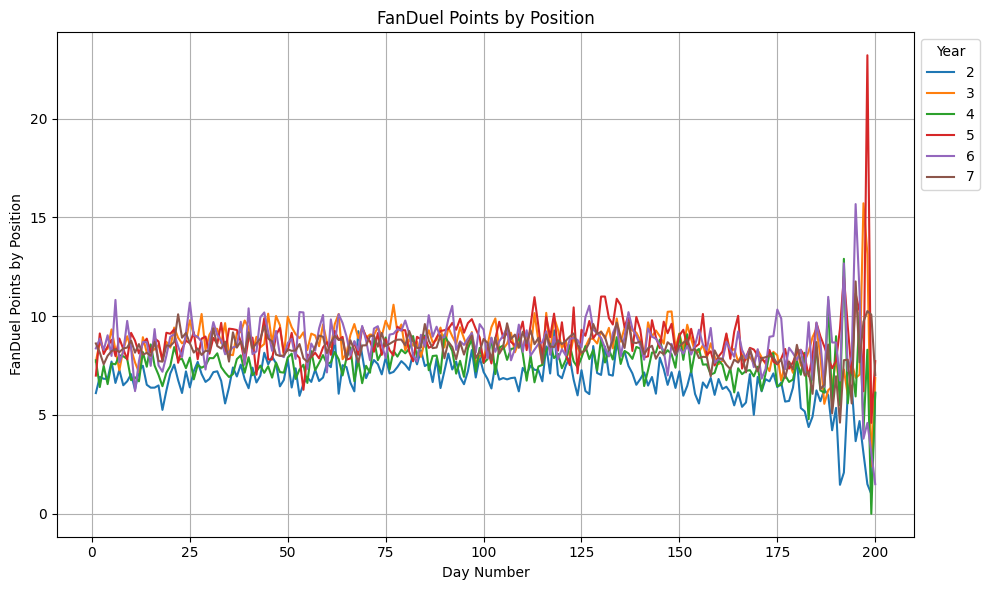

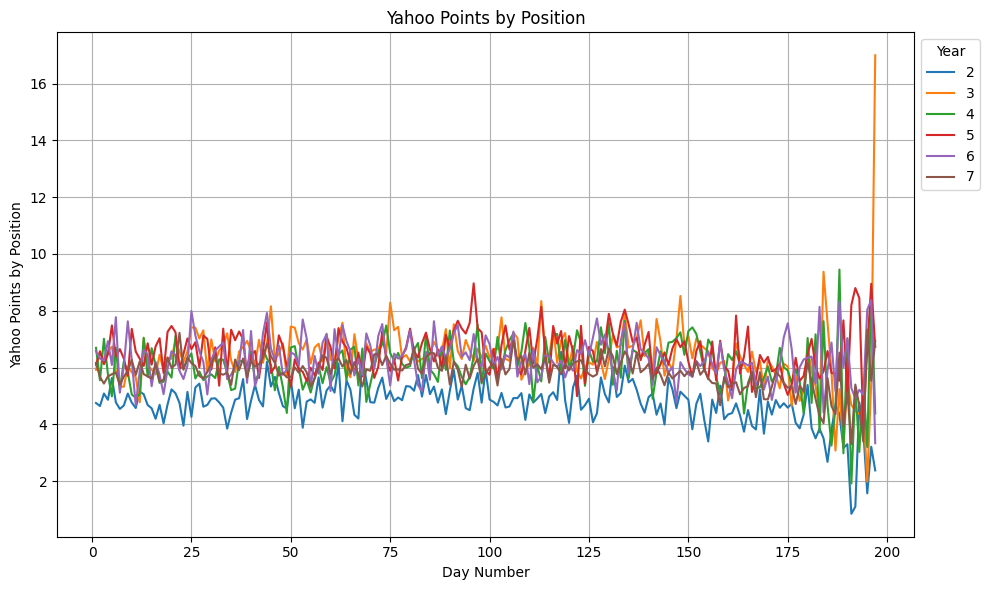

In [15]:
plot_long_data_company(hitter_df, "dk", 'DraftKings Points by Position', 'dk_points', ["day_num", 'Position'])
plot_long_data_company(hitter_df, "fd", 'FanDuel Points by Position', 'fd_points', ["day_num", 'Position'])
plot_long_data_company(hitter_df, "yh", 'Yahoo Points by Position', 'yh_points', ["day_num", 'Position'])

# Predicting Player Salary

## Create Train, Test, and Validation sets

In [26]:
valid_df = hitter_df.copy()[hitter_df['year'] == 2021]
test_df = hitter_df.copy()[hitter_df['year'] == 2020]
train_df = hitter_df.copy()[hitter_df['year'] != 2021]
train_df = train_df[train_df['year'] != 2020]

## More Feature Engineering to get data prepped for GLM

In [27]:
import numpy as np

def take_care_of_na(df):
    df['avg_hit_distance'].fillna(df['avg_hit_distance'].mean(), inplace=True)
    df['avg_launch_speed'].fillna(df['avg_launch_speed'].mean(), inplace=True) 
    df['avg_launch_angle'].fillna(df['avg_launch_angle'].mean(), inplace=True)
    df['estimated_ba_using_speedangle'].fillna(df['estimated_ba_using_speedangle'].mean(),
                                               inplace=True)
    df['estimated_woba_using_speedangle'].fillna(df['estimated_woba_using_speedangle'].mean(),
                                                 inplace=True)    

def add_date_info(df):
    df['game_date'] = pd.to_datetime(df['game_date'])
    df['day_of_week'] = df['game_date'].dt.dayofweek
    df['angular_date'] = 2 * np.pi * df['day_of_week'] / 7
    
def add_lagged_info(df, lagged_column, lags, group):
    for lag in range(1, lags + 1):
        df[lagged_column + "_lagged_" + str(lag)] = df.groupby(group)[lagged_column].shift(lag)
    df[lagged_column + "_next"] = df.groupby(group)[lagged_column].shift(-1)
    df.dropna(subset=[lagged_column + "_lagged_" + str(lags)], inplace=True)
    df.dropna(subset=[lagged_column + "_next"], inplace=True)
    
def clean_for_lms(df, lagged_column, lags, group):
    take_care_of_na(df)
    add_date_info(df)
    add_lagged_info(df, lagged_column, lags, group)

In [28]:
clean_for_lms(train_df, 'dk_salary', 5, ['Name', 'year'])
clean_for_lms(test_df, 'dk_salary', 5, ['Name', 'year'])
clean_for_lms(valid_df, 'dk_salary', 5, ['Name', 'year'])

## EDA

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229474 entries, 1216 to 247782
Data columns (total 54 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Position                         229474 non-null  object        
 1   Name                             229474 non-null  object        
 2   dk_points                        229474 non-null  float64       
 3   dk_salary                        229474 non-null  float64       
 4   Team                             229474 non-null  object        
 5   Opp                              229474 non-null  object        
 6   Score                            229474 non-null  object        
 7   year                             229474 non-null  int64         
 8   fd_points                        229474 non-null  float64       
 9   fd_salary                        140479 non-null  float64       
 10  yh_points                        145197 non-nu

In [32]:
vis_df = train_df[['Position', 'dk_points', 'dk_salary', 'year', 'dk_salary_lagged_1', 
          'dk_salary_lagged_2', 'dk_salary_lagged_3', 'dk_salary_lagged_4', 'dk_salary_lagged_5',
          'dk_salary_next']]

vis_df.corr(numeric_only=True)['dk_salary_next']

dk_points             0.215396
dk_salary             0.899049
year                  0.203819
dk_salary_lagged_1    0.873762
dk_salary_lagged_2    0.853598
dk_salary_lagged_3    0.841461
dk_salary_lagged_4    0.832314
dk_salary_lagged_5    0.820335
dk_salary_next        1.000000
Name: dk_salary_next, dtype: float64

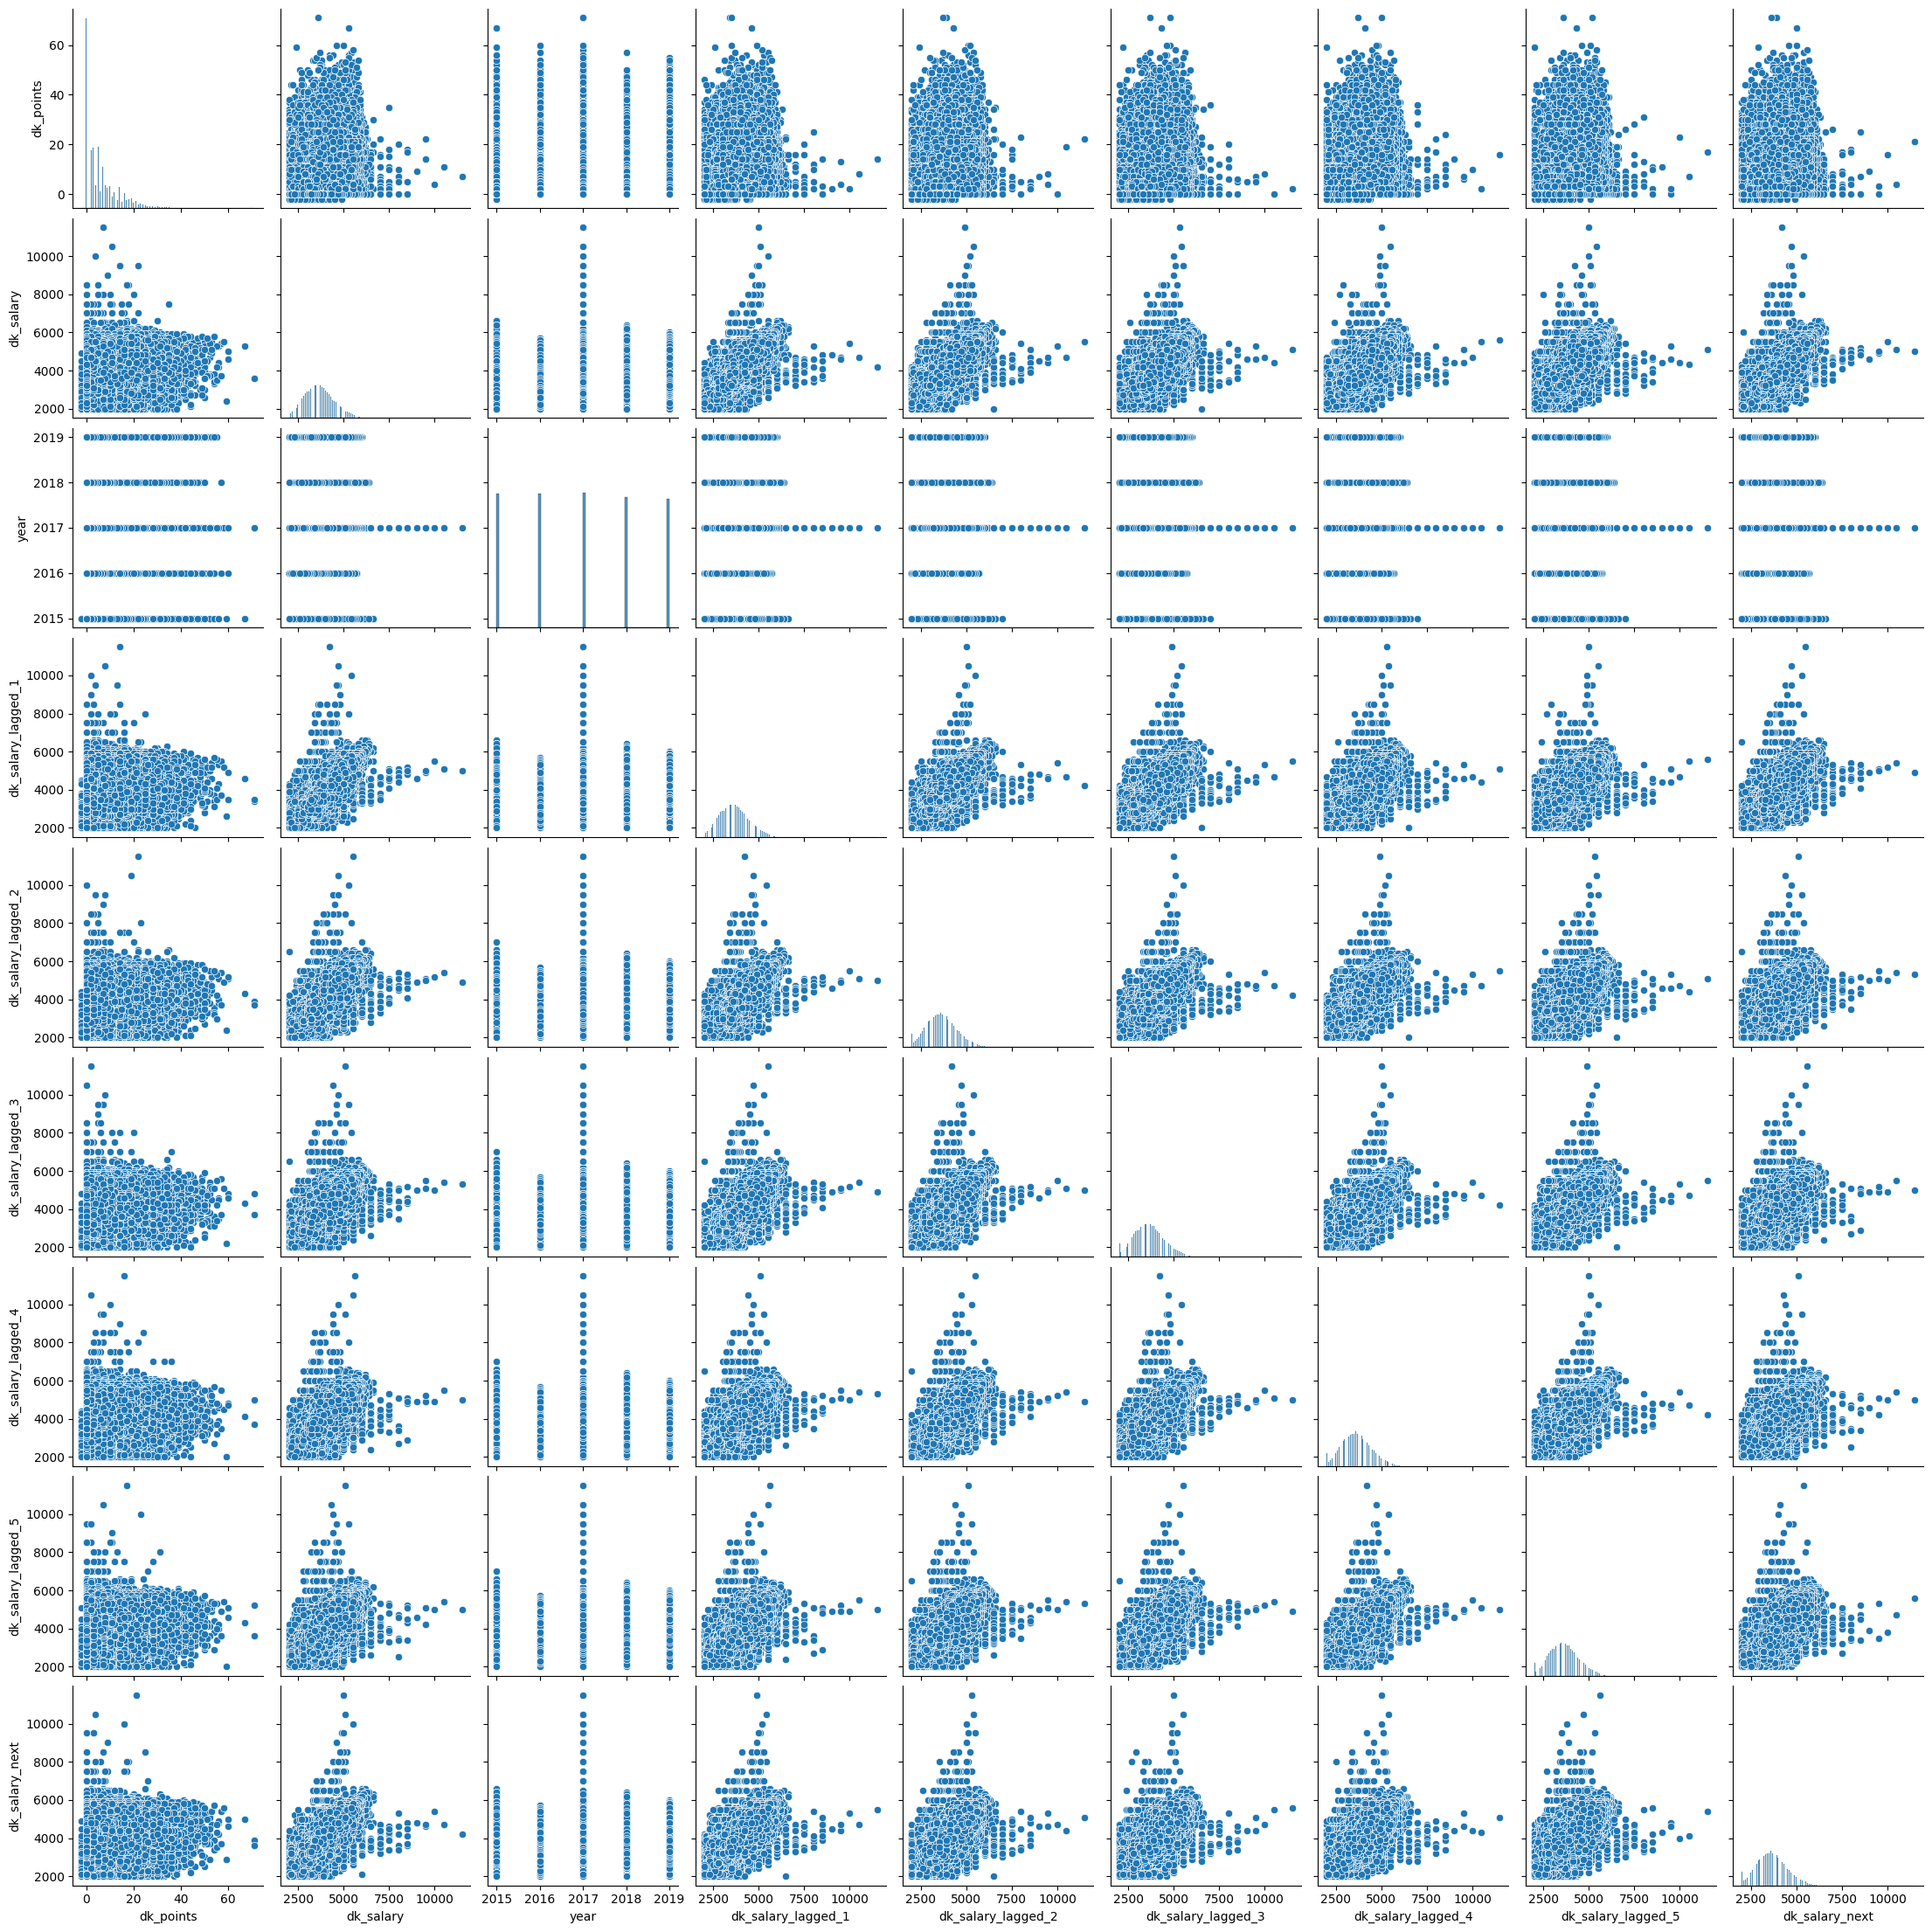

In [34]:
import seaborn as sns

sns.pairplot(vis_df)

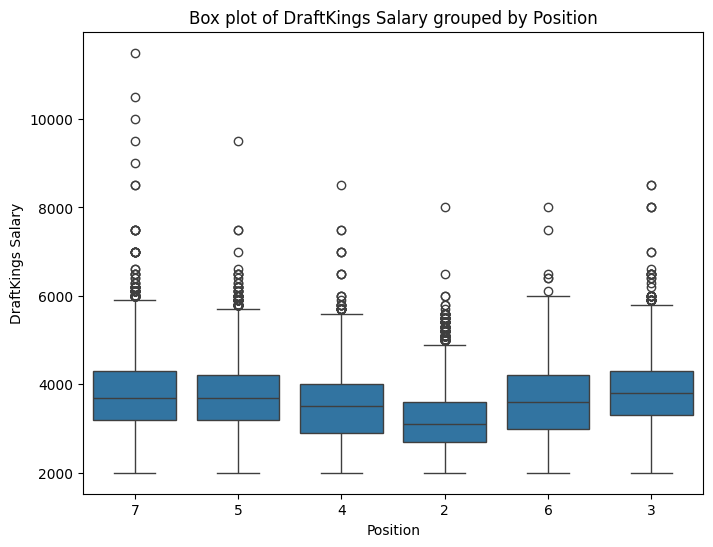

In [38]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Position', y='dk_salary', data=train_df)
plt.title('Box plot of DraftKings Salary grouped by Position')
plt.xlabel('Position')
plt.ylabel('DraftKings Salary')
plt.show()

## Fitting Linear Model

### Model Fitting Functions

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2

### Plot Helper Functions

In [114]:
def plot_qq(residuals):
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.qqplot(residuals, line='s', ax=ax)
    plt.title("QQ Plot of Residuals")
    plt.show() 
    
def plot_acf_pacf(residuals):
    plot_acf(residuals, lags=40)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function (ACF) of Residuals')
    plt.show()

    plot_pacf(residuals, lags=40)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title('Partial Autocorrelation Function (PACF) of Residuals')
    plt.show() 
    
def plot_resids_over_time(residuals, df, ylab):
    mod_df = df.copy()[['year', 'day_num', 'Position']]
    mod_df['resid'] = residuals 

    grouped_df = mod_df.groupby(['day_num','Position'])['resid'].mean().unstack()

    plt.figure(figsize=(10, 6))
    for column in grouped_df.columns:
        plt.plot(grouped_df.index, grouped_df[column], label=str(column))

    plt.xlabel('Day Number')
    plt.ylabel('Resid ' + ylab) 
    plt.title('Resid ' + ylab + ' for Each Day by Position')
    plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

def plot_me_residuals(residuals, df, ylab):
    plot_qq(residuals)
    plot_resids_over_time(residuals, df, ylab)
    
def get_mse_and_rmse(df, model_result, outcome_name):
    actual = df[outcome_name]
    pred = model_result.predict(df)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    
    return mse, rmse
    
def evaluate_me_model(model_result, df, ylab):
    print(model_result.summary())
    for group, effect in model_result.random_effects.items():
        print(f"Group: {group}, Random Effect: {effect}")
    plot_me_residuals(model_result.resid, df, ylab)

def lrt(mod1_result, mod2_result, dif):
    llf_diff = mod1_result.llf - mod2_result.llf

    test_stat = -2 * llf_diff
    p_value = 1 - chi2.cdf(test_stat, dif)

    print("Likelihood Ratio Test (LRT) Results:")
    print("Test statistic:", test_stat)
    print("P-value:", p_value) 
    
    
def print_rmse_by_pos(df, pred, pred_column):
    df = df.copy()
    df['pred'] = pred 
    rmse_by_pos = df.groupby('Position').apply(lambda x: np.sqrt(mean_squared_error(x[pred_column], x['pred'])))
    print("RMSE by Position:")
    for position, rmse in rmse_by_pos.items():
        print(f"{position}: {rmse}") 

## Linear Regression

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
scores_mod_1 = cross_val_score(lm, 
                               train_df.copy()[['dk_points']], 
                               train_df.dk_salary_next,
                               cv=5,
                               scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores_mod_1)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

RMSE scores for each fold: [846.78324846 808.95379523 769.06191804 720.11266991 791.64339141]
Mean RMSE: 787.3110046116378


In [37]:
lm = LinearRegression()
columns = ['dk_points', 'avg_hit_distance', 'avg_launch_speed', 'avg_launch_angle',
           'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'angular_date', 'dk_salary_lagged_1', 'dk_salary_lagged_2', 'dk_salary_lagged_3', 'dk_salary_lagged_4', 'dk_salary_lagged_5', 'dk_salary']
scores_mod_1 = cross_val_score(lm, 
                               train_df.copy()[columns], 
                               train_df.dk_salary_next,
                               cv=5,
                               scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores_mod_1)
print("Training RMSE scores for each fold:", rmse_scores)
print("Trainng Mean RMSE:", np.mean(rmse_scores))

Training RMSE scores for each fold: [280.37691243 426.43967481 338.04983058 243.13556471 273.74515615]
Trainng Mean RMSE: 312.34942773266806


In [40]:
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(lm, train_df.copy()[columns], train_df.dk_salary_next, cv=5)

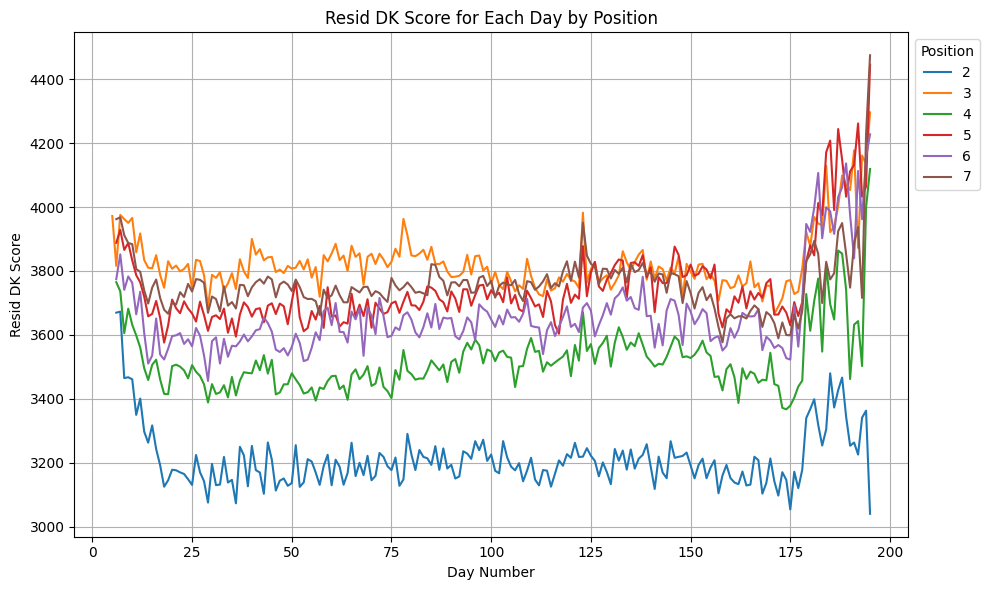

In [41]:
plot_resids_over_time(pred, train_df, "DK Score")

In [72]:
lm.fit(train_df.copy()[columns], train_df.dk_salary_next)
test_pred = lm.predict(test_df.copy()[columns])
actual = test_df.dk_salary_next

mse = mean_squared_error(actual, test_pred)
rmse = np.sqrt(mse)

print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)

Test Mean Squared Error (MSE): 99843.76665126905
Test Root Mean Squared Error (RMSE): 315.98064284267326


In [73]:
print_rmse_by_pos(test_df, test_pred, 'dk_salary_next')


RMSE by Position:
2: 324.5148155175047
3: 327.76663397581393
4: 326.3517725861355
5: 302.6285250363328
6: 316.30315558651967
7: 307.3858988303578


## Mixed Effects Models

In [43]:
def fit_me_fixed_int(formula, train_df, intercept):
    mod = smf.mixedlm(formula, train_df, groups=train_df[intercept])
    mod_result = mod.fit() 
    
    return mod_result

def print_mse_rmse(test_df, model_results, outcome_name, mod_name):
    mse, rmse = get_mse_and_rmse(test_df, model_results, outcome_name)
    
    print(mod_name + " MSE: " + str(mse))
    print(mod_name + " RMSE: " + str(rmse))

### First Mixed Effects Model: Predicting Salary based on points from previous game with random intercept for each position

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dk_salary_next
No. Observations: 212296  Method:             REML          
No. Groups:       6       Scale:              570326.9089   
Min. group size:  20088   Log-Likelihood:     -1708134.5803 
Max. group size:  73096   Converged:          Yes           
Mean group size:  35382.7                                   
------------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   3476.479   87.414 39.770 0.000 3305.150 3647.807
dk_points     22.056    0.229 96.140 0.000   21.606   22.505
Group Var  45815.052   35.702                               

Group: 2, Random Effect: Group   -400.96064
dtype: float64
Group: 3, Random Effect: Group    203.68278
dtype: float64
Group: 4, Random Effect: Group   -90.667756
dtype: float64
Group: 5, Random Effect: Group    118.997

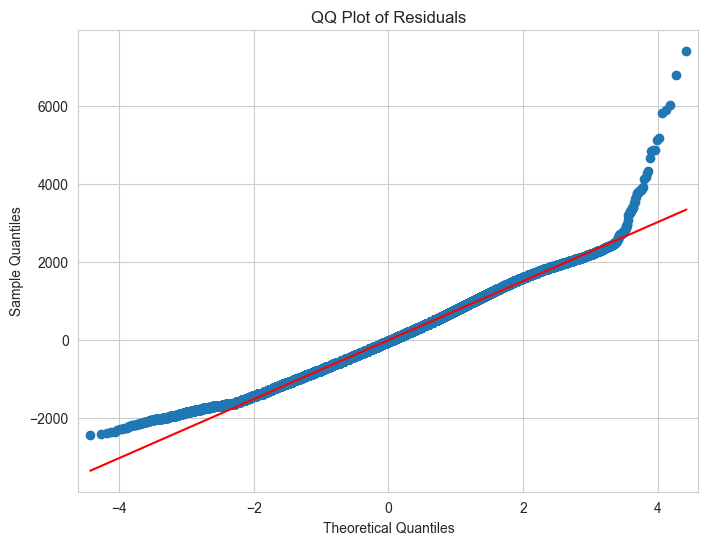

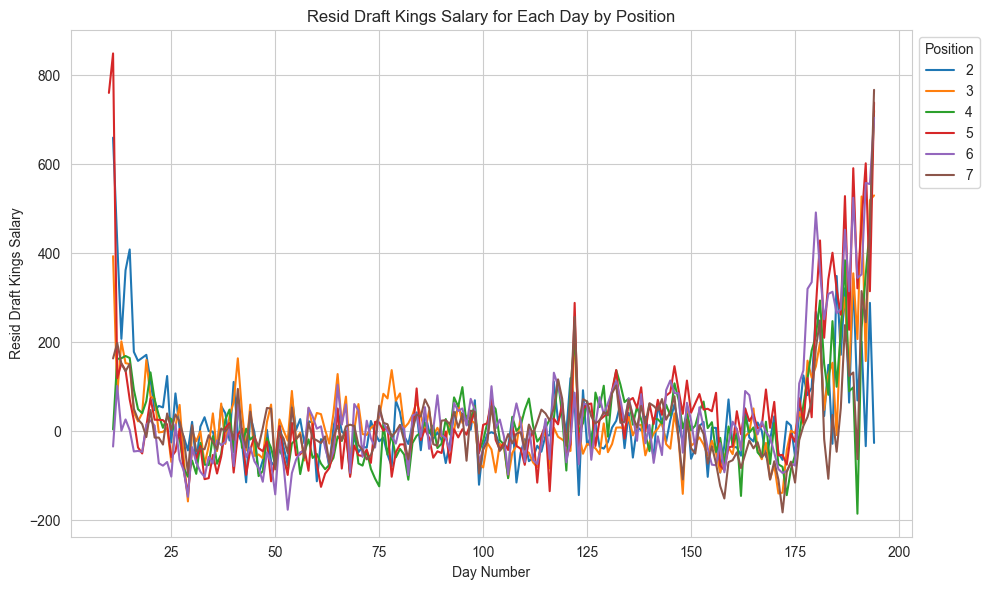

In [115]:
mod1_formula = "dk_salary_next ~ dk_points"
mod1_result = fit_me_fixed_int(mod1_formula, train_df, "Position")
evaluate_me_model(mod1_result, train_df, 'Draft Kings Salary')

In [45]:
print_mse_rmse(test_df, mod1_result, 'dk_salary_next', "Model 1")

Model 1 MSE: 954389.4637224472
Model 1 RMSE: 976.9285868078829


### Model 2: Including Statcast data

/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       dk_salary_next
No. Observations:       212296        Method:                   REML          
No. Groups:             6             Scale:                    122870.1394   
Min. group size:        20088         Log-Likelihood:           -1545187.7403 
Max. group size:        73096         Converged:                Yes           
Mean group size:        35382.7                                               
------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                       414.530   13.399  30.939 0.000 388.270 440.791
dk_points                         3.225    0.129  25.036 0.000   2.973   3.478
avg_hit_distance                 -0.080    0.016  -5.068 0.000  -0.111  -

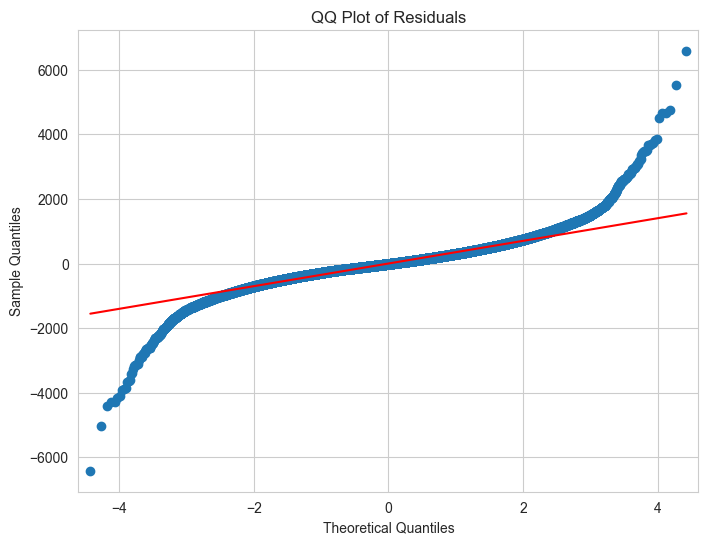

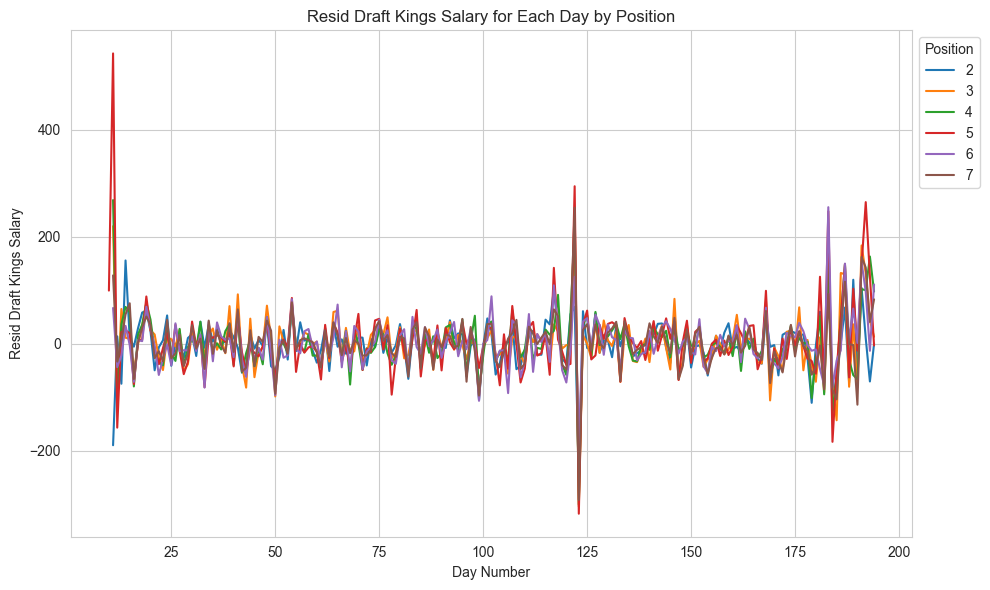

In [116]:
mod2_formula = "dk_salary_next ~ dk_points + avg_hit_distance + avg_launch_speed + avg_launch_angle + estimated_ba_using_speedangle + estimated_woba_using_speedangle + dk_salary"
mod2_result = fit_me_fixed_int(mod2_formula, train_df, "Position")
evaluate_me_model(mod2_result, train_df, 'Draft Kings Salary')

In [50]:
print_mse_rmse(test_df, mod2_result, 'dk_salary_next', "Model 2")

Model 2 MSE: 100286.15831402969
Model 2 RMSE: 316.67989881587005


In [51]:
lrt(mod1_result, mod2_result, 6)

Likelihood Ratio Test (LRT) Results:
Test statistic: 356046.6093952139
P-value: 0.0


In [ ]:
print_mse_rmse(train_df, mode)

### Model 3: Including date information

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       dk_salary_next
No. Observations:       229474        Method:                   REML          
No. Groups:             6             Scale:                    120962.8158   
Min. group size:        21389         Log-Likelihood:           -1668420.7743 
Max. group size:        78901         Converged:                Yes           
Mean group size:        38245.7                                               
------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                       408.933   13.135  31.134 0.000 383.189 434.676
dk_points                         3.263    0.124  26.415 0.000   3.021   3.505
dk_salary                         0.887    0.001 921.552 0.000   0.885   

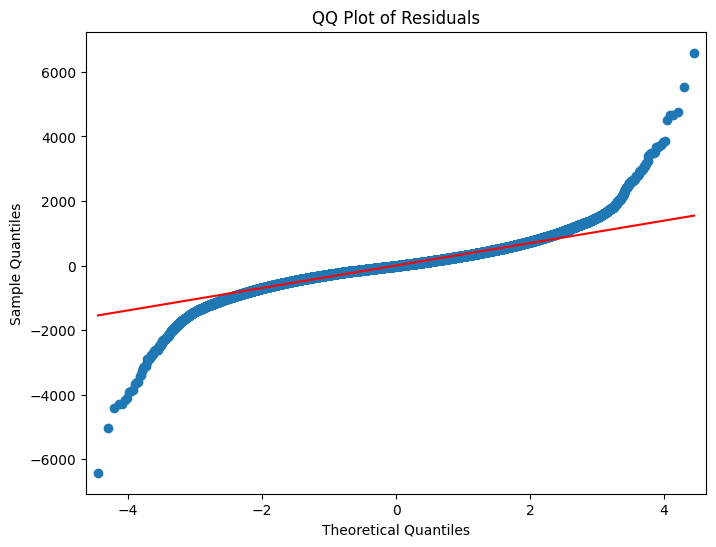

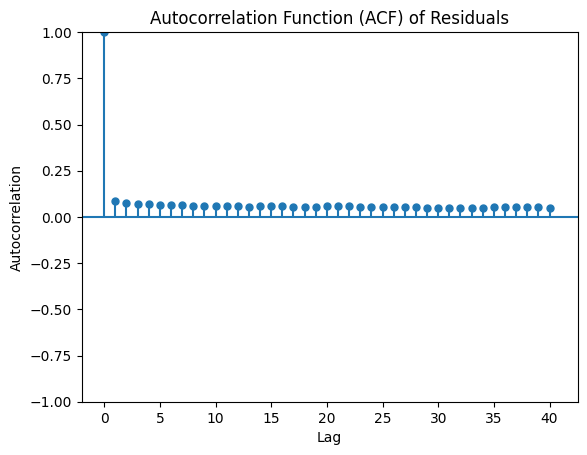

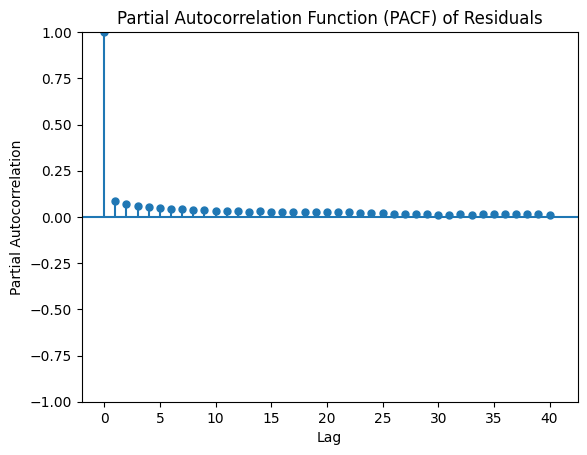

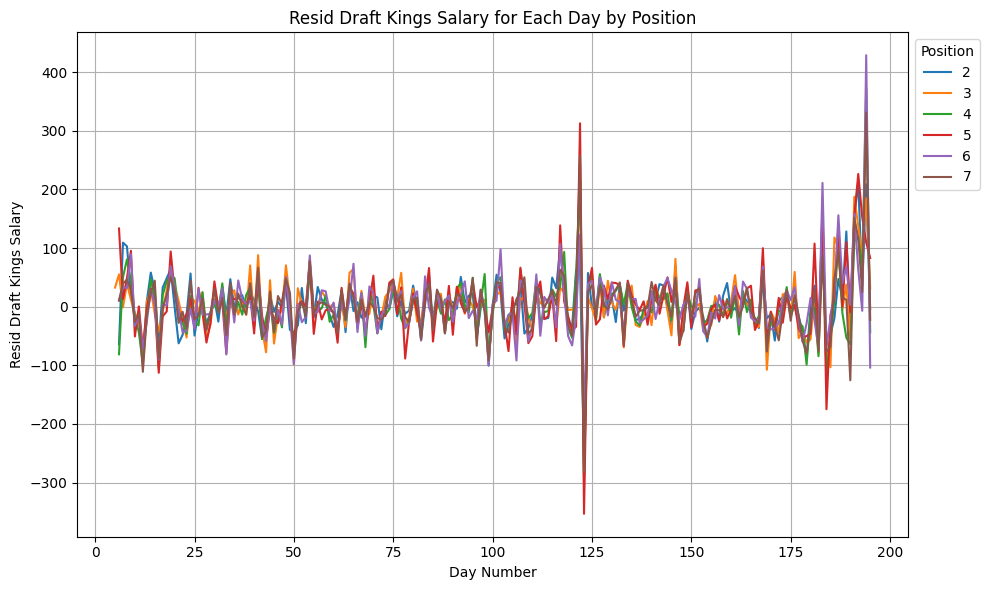

In [55]:
mod3_formula = 'dk_salary_next ~ dk_points + dk_salary + avg_hit_distance + avg_launch_speed + avg_launch_angle + estimated_ba_using_speedangle + estimated_woba_using_speedangle + angular_date'
mod3_result = fit_me_fixed_int(mod3_formula, train_df, "Position")
evaluate_me_model(mod3_result, train_df, 'Draft Kings Salary') 

In [56]:
print_mse_rmse(test_df, mod3_result, 'dk_salary_next', "Model 3")

Model 3 MSE: 100428.45106011804
Model 3 RMSE: 316.9044825497393


In [57]:
lrt(mod2_result, mod3_result, 1)

Likelihood Ratio Test (LRT) Results:
Test statistic: 24.049221608787775
P-value: 9.390421544797078e-07


### Model 4: Including Lagged data

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       dk_salary_next
No. Observations:       229474        Method:                   REML          
No. Groups:             6             Scale:                    100571.9823   
Min. group size:        21389         Log-Likelihood:           -1647259.7225 
Max. group size:        78901         Converged:                Yes           
Mean group size:        38245.7                                               
------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                       168.695    8.641  19.522 0.000 151.758 185.631
dk_points                         2.906    0.113  25.799 0.000   2.686   3.127
avg_hit_distance                 -0.035    0.014  -2.584 0.010  -0.062  -

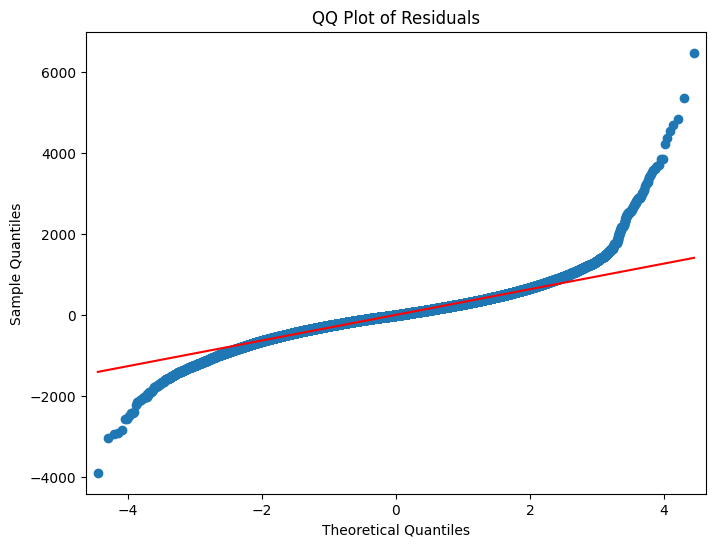

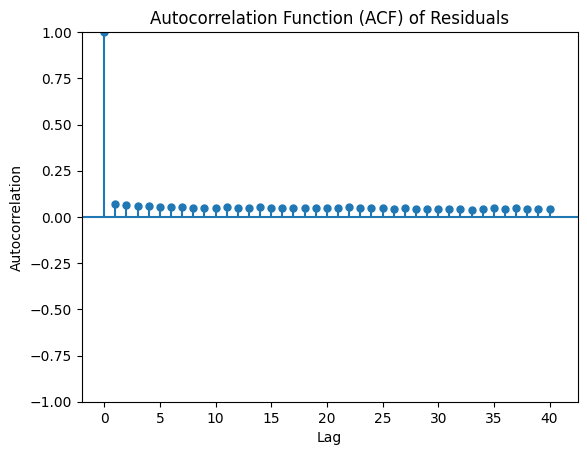

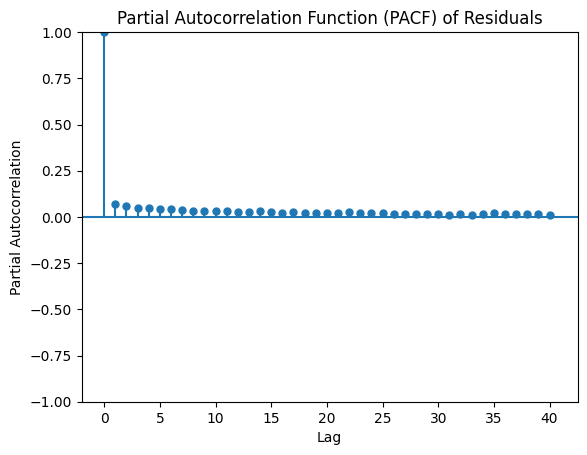

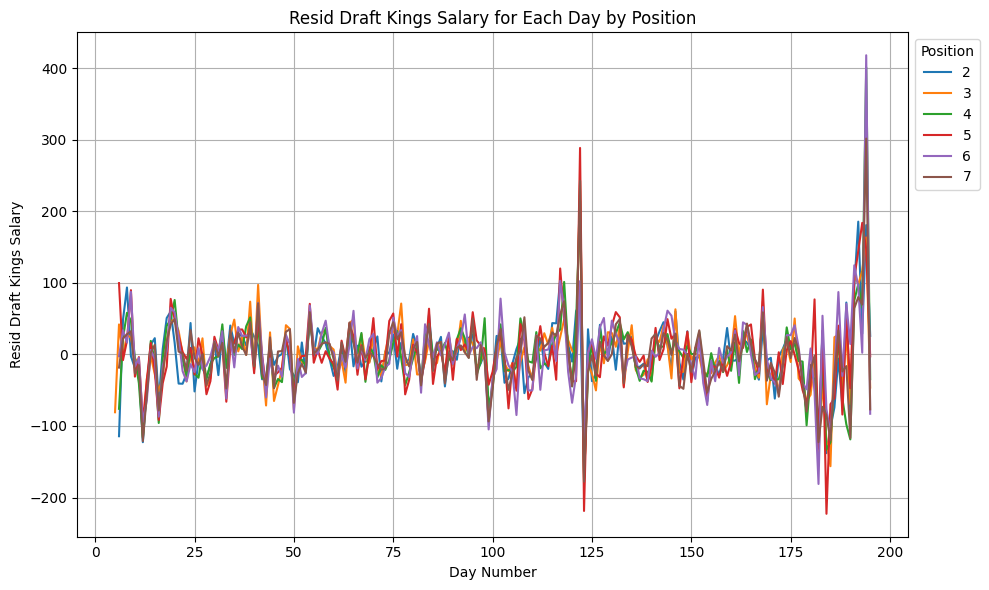

In [58]:
mod4_formula = ('dk_salary_next ~ dk_points + avg_hit_distance + avg_launch_speed '
                '+ avg_launch_angle + estimated_ba_using_speedangle '
                '+ estimated_woba_using_speedangle + angular_date '
                '+ dk_salary_lagged_2 + dk_salary_lagged_3 + dk_salary_lagged_4 '
                '+ dk_salary_lagged_5 + dk_salary_lagged_1 + dk_salary')
                
mod4_result = fit_me_fixed_int(mod4_formula, train_df, "Position")
evaluate_me_model(mod4_result, train_df, 'Draft Kings Salary') 

In [61]:
print_mse_rmse(test_df, mod4_result, "dk_salary_next", "Model 4")

Model 4 MSE: 99896.92200078207
Model 4 RMSE: 316.0647433687947


In [64]:
lrt(mod3_result, mod4_result, 5)

Likelihood Ratio Test (LRT) Results:
Test statistic: 42322.10362089891
P-value: 0.0


In [66]:
mod4_result.predict(test_df)

249158    4182.334635
249168    3441.539131
249176    3362.320086
249178    4597.408291
249181    2378.321596
             ...     
264109    3527.434793
264110    3635.763997
264111    3288.675337
264112    3093.690339
264113    2617.245204
Length: 13081, dtype: float64

In [75]:
print_rmse_by_pos(test_df, mod4_result.predict(test_df), 'dk_salary_next')

RMSE by Position:
2: 324.4731557424684
3: 327.79911161912077
4: 326.3643570866399
5: 302.8498781061731
6: 316.63657322558805
7: 307.45401083924463


## XGBoost

In [109]:
train_df

Position               Name  dk_points  dk_salary Team       Opp Score  \
1216          7          Matt Kemp       20.0     4200.0  SDG  away_sfo  10-2   
1232          7          Wil Myers       16.0     3500.0  SDG  away_sfo  10-2   
1235          5      Adrian Beltre       15.0     5100.0  TEX  away_hou   6-2   
1238          5  Will Middlebrooks       15.0     2900.0  SDG  away_sfo  10-2   
1242          7       Justin Upton       14.0     3900.0  SDG  away_sfo  10-2   
...         ...                ...        ...        ...  ...       ...   ...   
247820        7    Randy Arozarena        0.0     3600.0  STL  away_was   4-7   
247821        4       Brian Dozier        0.0     3500.0  WAS  away_stl   7-4   
247822        2       Matt Wieters        0.0     3300.0  STL  away_was   4-7   
247823        7     Jake Marisnick        0.0     3200.0  HOU  away_nyy   4-1   
247824        5        Yairo Munoz        0.0     3000.0  STL  away_was   4-7   

        year  fd_points  fd_salary  ...  position_6  position_7  day_num  \
1216    2015       24.7     3900.0  ...       False        True        6   
1232    2015       22.4     3100.0  ...       False        True        6   
1235    2015       18.2     3900.0  ...       False       False        6   
1238    2015       19.0     2400.0  ...       False       False        6   
1242    2015       19.4     3900.0  ...       False        True        6   
...      ...        ...        ...  ...         ...         ...      ...   
247820  2019        0.0     2000.0  ...       False        True      194   
247821  2019        0.0     2400.0  ...       False       False      194   
247822  2019        0.0     2300.0  ...       False       False      194   
247823  2019        0.0     2300.0  ...       False        True      194   
247824  2019        0.0        NaN  ...       False        True      194   

        day_of_week  angular_date  dk_salary_lagged_1  dk_salary_lagged_2  \
1216              5      4.487990              4600.0              4700.0   
1232              5      4.487990              3800.0              3900.0   
1235              5      4.487990              5200.0              4500.0   
1238              5      4.487990              3200.0              3300.0   
1242              5      4.487990              4300.0              4500.0   
...             ...           ...                 ...                 ...   
247820            1      0.897598              3500.0              3700.0   
247821            1      0.897598              3500.0              3600.0   
247822            1      0.897598              3200.0              3500.0   
247823            1      0.897598              3200.0              3000.0   
247824            1      0.897598              3100.0              3200.0   

        dk_salary_lagged_3  dk_salary_lagged_4  dk_salary_lagged_5  
1216                4700.0              4300.0              4000.0  
1232                3900.0              3600.0              3300.0  
1235                4500.0              4600.0              4400.0  
1238                3200.0              3000.0              2800.0  
1242                4500.0              4000.0              3800.0  
...                    ...                 ...                 ...  
247820              3800.0              3900.0              3800.0  
247821              3300.0              3500.0              3500.0  
247822              3000.0              3300.0              3500.0  
247823              3000.0              3300.0              3500.0  
247824              3600.0              4200.0              3300.0  

[232461 rows x 53 columns]

In [82]:
import xgboost as xgb

train_x = train_df[['dk_points', 'avg_hit_distance', 'avg_launch_speed',
                   'avg_launch_angle', 'estimated_ba_using_speedangle',
                   'estimated_woba_using_speedangle', 'angular_date', 'dk_salary_lagged_1',
                   'dk_salary_lagged_2', 'dk_salary_lagged_3', 'dk_salary_lagged_4',
                   'dk_salary_lagged_5', 'position_2', 'position_3', 'position_4',
                    'position_5', 'position_6', 'position_7', 'dk_salary']]

train_y = train_df[['dk_salary_next']]

test_x = test_df[['dk_points', 'avg_hit_distance', 'avg_launch_speed',
                   'avg_launch_angle', 'estimated_ba_using_speedangle',
                   'estimated_woba_using_speedangle', 'angular_date', 'dk_salary_lagged_1',
                   'dk_salary_lagged_2', 'dk_salary_lagged_3', 'dk_salary_lagged_4',
                   'dk_salary_lagged_5', 'position_2', 'position_3', 'position_4',
                    'position_5', 'position_6', 'position_7', 'dk_salary']]

test_y = test_df[['dk_salary_next']]

dtrain_reg = xgb.DMatrix(train_x, train_y, enable_categorical=True)
dtest_reg = xgb.DMatrix(test_x, test_y, enable_categorical=True)

## Baseline Model

In [83]:
params = {'objective': 'reg:squarederror'}
n = 100

model = xgb.train(
    dtrain=dtrain_reg,
    params=params,
    num_boost_round=n
)

pred = model.predict(dtest_reg)
np.sqrt(mean_squared_error(test_y, pred))

318.07202320406253

In [84]:
params = {'objective': 'reg:squarederror'}
n = 2600

# Add evals:
evals = [(dtrain_reg, 'train'), (dtest_reg, 'validation')]

model = xgb.train(
    dtrain=dtrain_reg,
    params=params,
    num_boost_round=n,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	train-rmse:605.55685	validation-rmse:740.60031
[10]	train-rmse:312.86238	validation-rmse:316.39737
[20]	train-rmse:309.98883	validation-rmse:314.98477
[29]	train-rmse:309.05077	validation-rmse:315.12484


# Predicting Player Score

In [85]:
clean_for_lms(train_df, 'dk_points', 5, ['Name', 'year'])
clean_for_lms(test_df, 'dk_points', 5, ['Name', 'year'])
clean_for_lms(valid_df, 'dk_points', 5, ['Name', 'year'])

## Linear Regression

In [86]:
lm = LinearRegression()
scores_mod_1 = cross_val_score(lm, 
                               train_df.copy()[['dk_salary']], 
                               train_df.dk_points_next,
                               cv=5,
                               scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores_mod_1)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))

RMSE scores for each fold: [6.70048174 7.00834189 7.16999243 6.91332264 7.30989308]
Mean RMSE: 7.020406355337565


In [87]:
lm = LinearRegression()
columns = ['dk_salary', 'dk_points', 'avg_hit_distance', 'avg_launch_speed', 'avg_launch_angle',
           'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'angular_date', 'dk_points_lagged_2', 'dk_points_lagged_3', 'dk_points_lagged_4', 'dk_points_lagged_5',
           'dk_points_lagged_1']
scores_mod_1 = cross_val_score(lm, 
                               train_df.copy()[columns], 
                               train_df.dk_points_next,
                               cv=5,
                               scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores_mod_1)
print("Training RMSE scores for each fold:", rmse_scores)
print("Trainng Mean RMSE:", np.mean(rmse_scores))

Training RMSE scores for each fold: [6.68582838 6.98419664 7.15419603 6.89111241 7.29588011]
Trainng Mean RMSE: 7.002242712560135


In [88]:
pred = cross_val_predict(lm, train_df.copy()[columns], train_df.dk_points_next, cv=5)

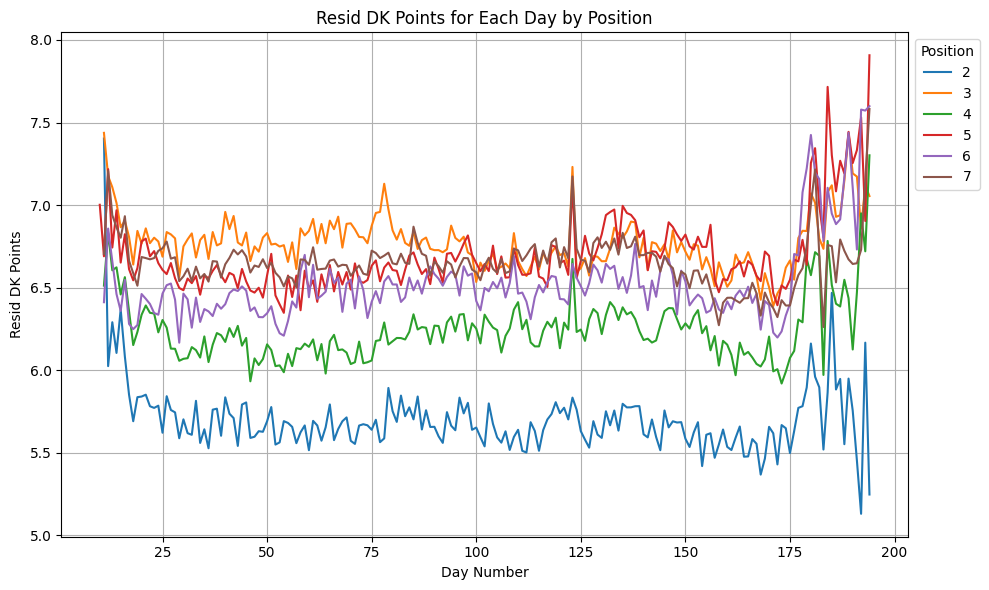

In [89]:
plot_resids_over_time(pred, train_df, "DK Points")

In [91]:
lm.fit(train_df.copy()[columns], train_df.dk_points_next)
test_pred = lm.predict(test_df.copy()[columns])
actual = test_df.dk_points_next

mse = mean_squared_error(actual, test_pred)
rmse = np.sqrt(mse)

print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", rmse)

Test Mean Squared Error (MSE): 53.344001096395694
Test Root Mean Squared Error (RMSE): 7.303697768691944


## Mixed Effects Model

/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dk_points_next
No. Observations: 212296  Method:             REML          
No. Groups:       6       Scale:              49.2774       
Min. group size:  20088   Log-Likelihood:     -714963.8595  
Max. group size:  73096   Converged:          Yes           
Mean group size:  35382.7                                   
-------------------------------------------------------------
               Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.279     0.115   2.420  0.016   0.053   0.505
dk_salary      0.002     0.000  85.903  0.000   0.002   0.002
Group Var      0.047     0.004                               

Group: 2, Random Effect: Group   -0.2434
dtype: float64
Group: 3, Random Effect: Group   -0.058122
dtype: float64
Group: 4, Random Effect: Group   -0.147495
dtype: float64
Group: 5, Random Effect: Group    0.2432

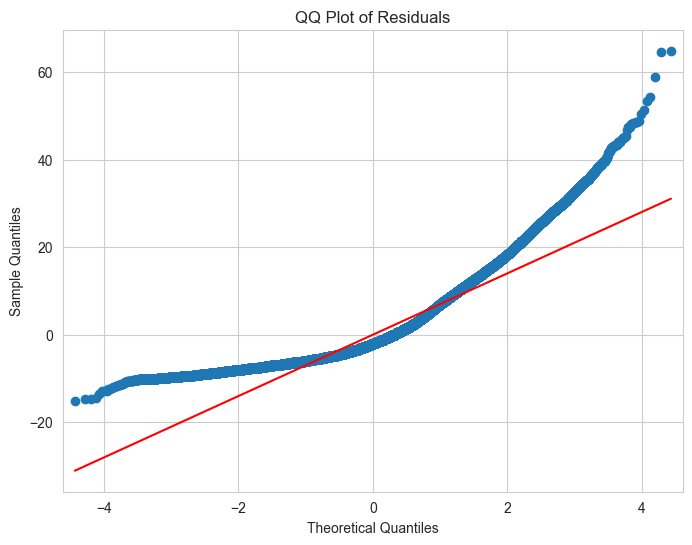

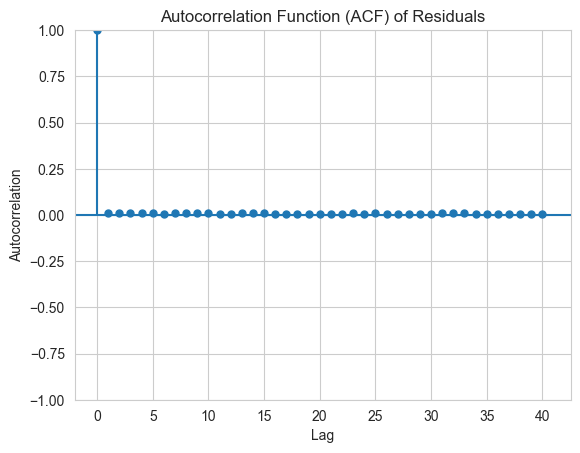

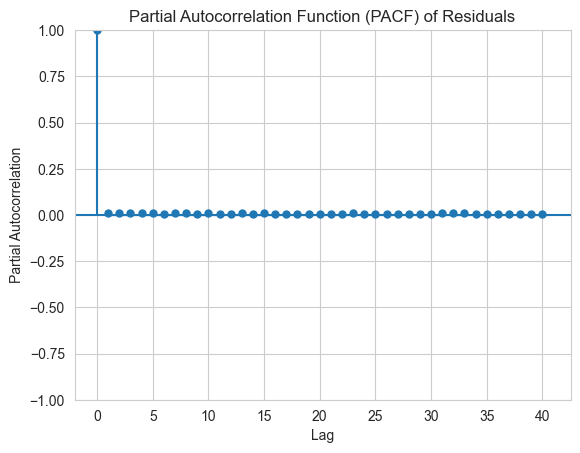

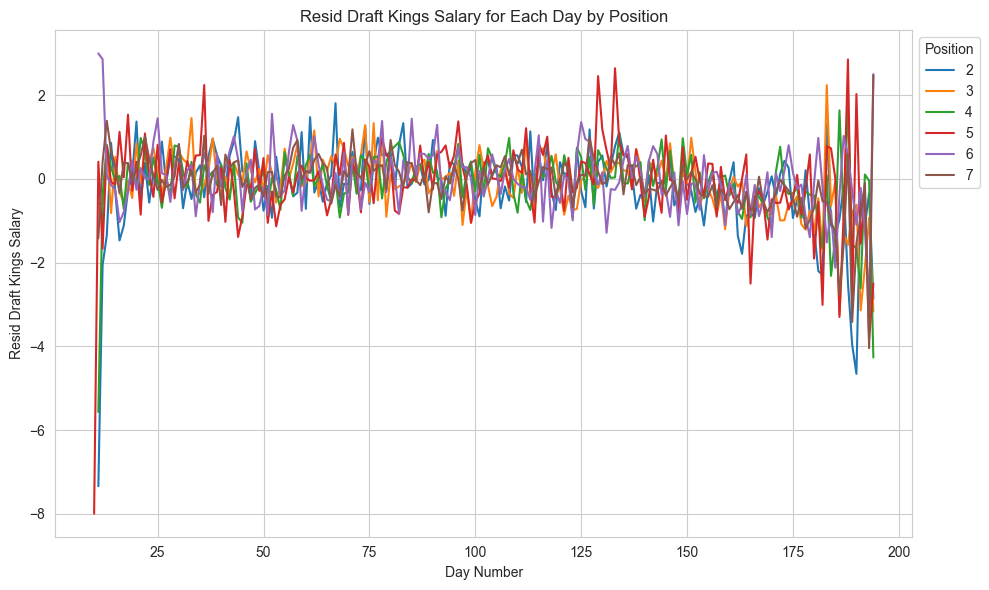

In [94]:
mod1_points_formula = "dk_points_next ~ dk_salary"
mod1_points_result = fit_me_fixed_int(mod1_points_formula, train_df, "Position")
evaluate_me_model(mod1_points_result, train_df, 'Draft Kings Salary')

In [95]:
print_mse_rmse(test_df, mod1_points_result, 'dk_points_next', "Model 1")

Model 1 MSE: 53.641713006155804
Model 1 RMSE: 7.324050314283471


/usr/local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     dk_points_next
No. Observations:       212296      Method:                 REML          
No. Groups:             6           Scale:                  49.0301       
Min. group size:        20088       Log-Likelihood:         -714478.7722  
Max. group size:        73096       Converged:              Yes           
Mean group size:        35382.7                                           
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       -0.450    0.189 -2.380 0.017 -0.821 -0.079
dk_points                        0.046    0.003 17.766 0.000  0.041  0.051
dk_salary                        0.001    0.000 59.126 0.000  0.001  0.001
avg_hit_distance                -0.000    0.

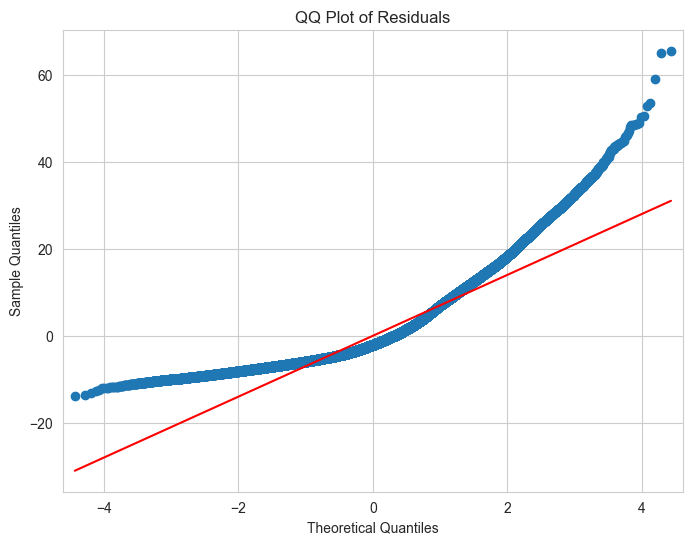

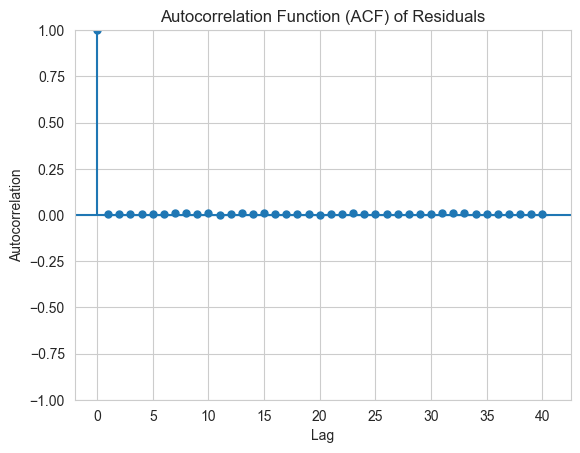

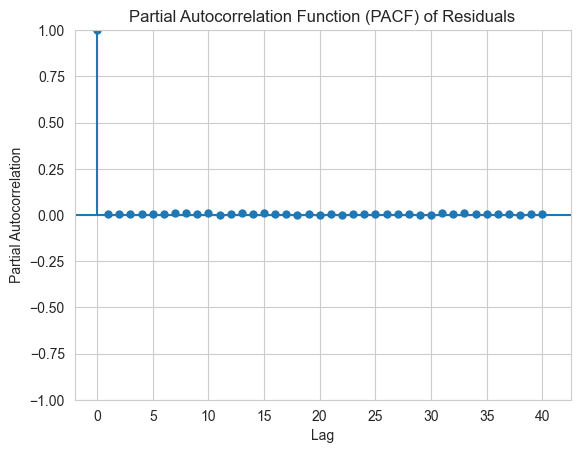

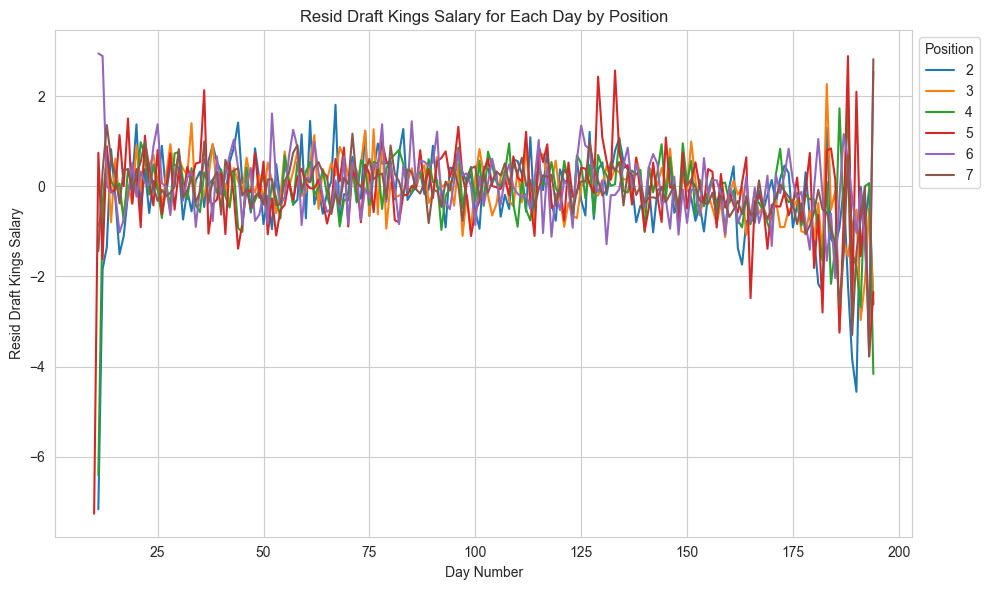

In [96]:
mod4_formula = ('dk_points_next ~ + dk_points + dk_salary + avg_hit_distance + avg_launch_speed '
                '+ avg_launch_angle + estimated_ba_using_speedangle '
                '+ estimated_woba_using_speedangle + angular_date '
                '+ dk_points_lagged_2 + dk_points_lagged_3 + dk_points_lagged_4 '
                '+ dk_points_lagged_5 + dk_points_lagged_1 + dk_points')
                
mod4_result = fit_me_fixed_int(mod4_formula, train_df, "Position")
evaluate_me_model(mod4_result, train_df, 'Draft Kings Points') 

In [98]:
print_mse_rmse(test_df, mod4_result, "dk_points_next", "Model 4")

Model 4 MSE: 53.33353249243322
Model 4 RMSE: 7.302981068880928


## XGBoost

In [110]:
import xgboost as xgb

var_cols = ['dk_points', 'avg_hit_distance', 'avg_launch_speed',
                   'avg_launch_angle', 'estimated_ba_using_speedangle',
                   'estimated_woba_using_speedangle', 'angular_date', 'dk_points_lagged_1',
                   'dk_points_lagged_2', 'dk_points_lagged_3', 'dk_points_lagged_4',
                   'dk_points_lagged_5', 'position_2', 'position_3', 'position_4',
                    'position_5', 'position_6', 'position_7', 'dk_salary']

pred_cols = ['dk_points_next']

train_x_points = train_df[var_cols]
train_y_points = train_df[pred_cols]

test_x_points = test_df[var_cols]
test_y_points = test_df[pred_cols]

dtrain_reg_points = xgb.DMatrix(train_x_points, train_y_points, enable_categorical=True)
dtest_reg_points = xgb.DMatrix(test_x_points, test_y_points, enable_categorical=True)

In [112]:
params = {'objective': 'reg:squarederror'}
n = 100

model_points = xgb.train(
    dtrain=dtrain_reg_points,
    params=params,
    num_boost_round=n
)

pred = model_points.predict(dtest_reg_points)
np.sqrt(mean_squared_error(test_y_points, pred))

7.356628742279575

In [113]:
params = {'objective': 'reg:squarederror'}
n = 2600

# Add evals:
evals = [(dtrain_reg_points, 'train'), (dtest_reg_points, 'validation')]

model_points = xgb.train(
    dtrain=dtrain_reg_points,
    params=params,
    num_boost_round=n,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)


[0]	train-rmse:7.07408	validation-rmse:7.35275
[10]	train-rmse:6.94935	validation-rmse:7.31312
[14]	train-rmse:6.93722	validation-rmse:7.31710
